# Clasificación de hongos y esporocarpos venenosos y comestibles

[Dataset utilizado](https://www.kaggle.com/datasets/marcosvolpato/edible-and-poisonous-fungi)

El proyecto se basa en generar un modelo capaz de clasificar hongos y esporocarpos comestibles y venenosos.

In [1]:
#!pip install pytorch_lightning

Empezamos importando las librerías a utilizar para este proyecto.

In [2]:
#librerias base
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, matthews_corrcoef, f1_score

#os y shutil para manejo de archivos y directorios
import os
import shutil

#cv2 para lectura de imágenes
import cv2

#torch, pytorch y pytorch lightning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split
from torchvision.utils import make_grid
import pytorch_lightning as pl
from pytorch_lightning import LightningModule

#tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#kaggle
import kagglehub

from PIL import Image

Montamos el drive donde tenemos guardado nuestro dataset.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path = 'drive/MyDrive/Dataset_Fungi/'

Hacemos una exploración del dataset:

El dataset completo cuenta con 3264 imágenes. Sin embargo, se eliminó manualmente el archivo cv (564) .jpg de la carpeta de poisonous mushroom sporocarp, ya que este archivo estaba corrupto y mandaba errores a la hora de querer leerlo.

In [5]:
classes=[]
paths=[]
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('.png') or filename.endswith('.jpg') :
            classes+=[dirname.split('/')[-1]]
            paths+=[(os.path.join(dirname, filename))]
print(len(paths))

3263


Vemos ahora las clases en las que estan divididas nuestras imágenes. Estas son 4:

*   Edible mushroom sporocarp (Hongo comestible)
*   Edible sporocarp (Esporocarpo comestible)
*   Poisonous mushroom sporocarp (Hongo venenoso)
*   Poisonous sporocarp (Esporocarpo venenoso)



In [6]:
N=list(range(len(classes)))
class_names=sorted(set(classes))
print(class_names)
normal_mapping=dict(zip(class_names,N))

data=pd.DataFrame(columns=['path','class'])
data['path']=paths
data['class']=classes
data['label']=data['class'].map(normal_mapping)
m=len(data)
M=list(range(m))
random.shuffle(M)
data=data.iloc[M]

['edible mushroom sporocarp', 'edible sporocarp', 'poisonous mushroom sporocarp', 'poisonous sporocarp']


Esta es la manera en la que se ve nuestro dataframe:

In [7]:
data.head()

,path,class,label
2617,drive/MyDrive/Dataset_Fungi/edible mushroom sp...,edible mushroom sporocarp,0
1893,drive/MyDrive/Dataset_Fungi/poisonous mushroom...,poisonous mushroom sporocarp,2
2581,drive/MyDrive/Dataset_Fungi/edible mushroom sp...,edible mushroom sporocarp,0
408,drive/MyDrive/Dataset_Fungi/poisonous sporocar...,poisonous sporocarp,3
3106,drive/MyDrive/Dataset_Fungi/edible sporocarp/n...,edible sporocarp,1


Crearemos una nueva columna con el fin de analizar el número de muestras comestibles y venenosas totales.

In [8]:
collapsed_mapping = {
    'edible mushroom sporocarp': 'edible',
    'poisonous mushroom sporocarp': 'poisonous',
    'edible sporocarp': 'edible',
    'poisonous sporocarp': 'poisonous'
}

data['collapsed_class'] = data['class'].map(collapsed_mapping)

Vemos ahora que nuestro dataset tiene en su mayoría imágenes de la clase "poisonous sporocarp" y, que en total las muestras venenosas son la mayoría.

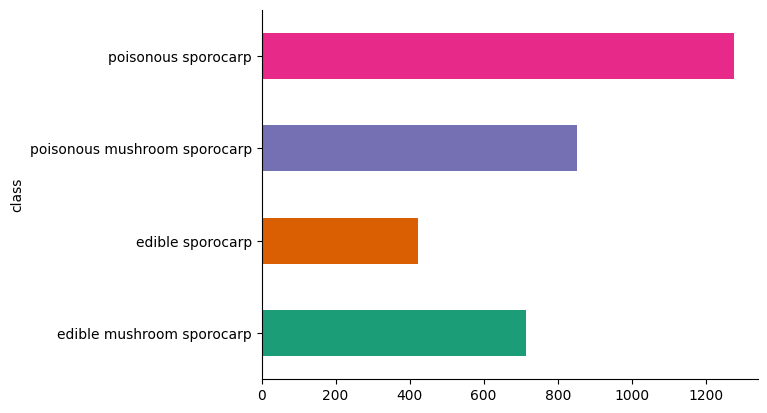

In [9]:
data.groupby('class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

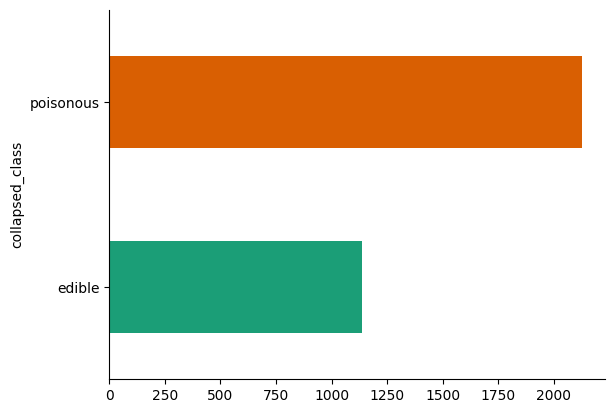

In [10]:
data.groupby('collapsed_class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Procedemos a mostrar unos ejemplos de clases venenosas y comestibles.


Class: edible


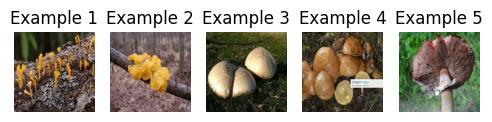


Class: poisonous


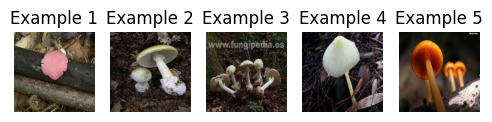

In [11]:
def show_example_images(data, num_images_per_class=5):
    for class_name in data['collapsed_class'].unique():
        class_data = data[data['collapsed_class'] == class_name]

        print(f"\nClass: {class_name}")

        # Sample num_images_per_class images from the current class
        example_image_paths = class_data['path'].sample(min(num_images_per_class, len(class_data)))

        plt.figure(figsize=(6, 5))  # Adjust figure size as needed

        for i, image_path in enumerate(example_image_paths):
            img = plt.imread(image_path)
            plt.subplot(1, num_images_per_class, i + 1)  # Create subplots for each image
            plt.imshow(img)
            plt.title(f"Example {i + 1}")
            plt.axis('off')  # Hide axis ticks and labels

        plt.show()

show_example_images(data)

A simple vista sería bastante difícil poder clasificarlos, no parece haber alguna diferencia notable ya sea en tamaño, figura o color.



---

Comezaremos ahora con el procesamiento de los datos.

Iniciando con las transformaciones que aplicaremos sobre las imágenes. Lo principal es intentar que todas las imágenes sean del mismo tamaño o similar, ya que este dataset cuenta con imágenes de tamaños muy variados. Se hacen algunas transformaciones adicionales como rotación.

In [12]:
transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

Crearemos nuestro dataset utilizando Pytorch.

In [13]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, path_label, transform=None):
        self.path_label = path_label
        self.transform = transform

    def __len__(self):
        return len(self.path_label)

    def __getitem__(self, idx):
        path, label = self.path_label[idx]
        img = Image.open(path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        return img, label

Dentro de las funciones de la clase ImageDataset procedemos a hacer el *split* de los datos como tal:

*   80% de los datos se utilizarán para entrenamiento
*   20% de los datos se utilizarán para validación



In [14]:
class ImageDataset(pl.LightningDataModule):
    def __init__(self, path_label, batch_size=32):
        super().__init__()
        self.path_label = path_label
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.Resize(224),             # resize shortest side to 224 pixels
            transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])

    def setup(self, stage=None):
        dataset = CustomDataset(self.path_label, self.transform)
        dataset_size = len(dataset)
        train_size = int(0.8 * dataset_size)
        val_size = int(0.2 * dataset_size)
        print(train_size,val_size)

        self.train_dataset = torch.utils.data.Subset(dataset, range(train_size))
        self.val_dataset = torch.utils.data.Subset(dataset, range(val_size))

    def __len__(self):
        if self.train_dataset is not None:
            return len(self.train_dataset)
        elif self.val_dataset is not None:
            return len(self.val_dataset)
        else:
            return 0

    def __getitem__(self, index):
        if self.train_dataset is not None:
            return self.train_dataset[index]
        elif self.test_dataset is not None:
            return self.test_dataset[index]
        else:
            raise IndexError("Index out of range. The dataset is empty.")

    def train_dataset(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataset(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

En la siguiente clase se especifican los parámetros de nuestro dataset de entrenamiento. Se aplicarán algunas transformaciones previamente establecidas a los datos.

In [15]:
class DataModule(pl.LightningDataModule):

    def __init__(self, transform=transform, batch_size=16):
        super().__init__()
        self.root_dir = path
        self.transform = transform
        self.batch_size = batch_size
        self.setup()
        self.prepare_data()


    def setup(self, stage=None):
        data_set = datasets.ImageFolder(root=self.root_dir, transform=self.transform)

        n_data = len(dataset)
        n_train = int(0.8 * n_data)
        n_val = int(0.2 * n_data)
        train_dataset, val_dataset =  random_split(dataset, [n_train, n_val])

        self.train_dataset = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.val_dataset = DataLoader(val_dataset, batch_size=self.batch_size)

    def train_dataloader(self):
        return self.train_dataset

    def val_dataloader(self):
        return self.val_dataset

    def test_dataloader(self):
        return self.test_dataset

Construimos nuestro modelo utilizando keras.

In [16]:
def get_model(base_model, hidden_layers, activation, output, output_activation, dropout=None, freeze_base_model=True):
    # freeze layers
    for lys in base_model.layers:
                lys.trainable = not freeze_base_model
    mdl = base_model.output

    for hl in hidden_layers:
        mdl = tf.keras.layers.Dense(hl, activation=activation)(mdl)
    if dropout:
        mdl = tf.keras.layers.Dropout(dropout)(mdl)
    mdl = tf.keras.layers.Dense(output, activation=output_activation)(mdl)
    model = tf.keras.models.Model(base_model.input, mdl)
    return model

Creamos nuestra lista de *paths* con la cual se accederá a los datos.

In [17]:
def create_path_label_list(df):
    path_label_list = []
    for _, row in df.iterrows():
        path = row['path']
        label = row['label']
        path_label_list.append((path, label))
    return path_label_list

path_label = create_path_label_list(data)
path_label = random.sample(path_label,len(path_label))

Inicializamos nuestro dataset, y revisamos que el número de muestras sea correcto para cada directorio (el de entrenamiento y el de validación).

In [18]:
dataset = ImageDataset(path_label)
dataset.setup()
train_dataloader = dataset.train_dataloader
val_dataloader = dataset.val_dataloader
datamodule = DataModule()

2610 652


Preparamos las imágenes para el entrenamiento y realizamos aumento de datos.

In [19]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)
batch_size = 32

Configuramos los dataset de entrenamiento y validación con sus respectivos generadores.

In [20]:
img_shape = (32,32)
train_gen = train_datagen.flow_from_directory(
    path,
    batch_size=batch_size,
    classes=class_names,
    class_mode='categorical',
    shuffle=True,
    target_size=img_shape,
    seed=42,
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    path,
    batch_size=batch_size,
    classes=class_names,
    class_mode='categorical',
    shuffle=True,
    target_size=img_shape,
    seed=42,
    subset='validation'
)

Found 2721 images belonging to 4 classes.
Found 679 images belonging to 4 classes.


Iniciamos ahora nuestro modelo para realizar el entrenamiento con los dataset establecidos.

In [32]:
model = tf.keras.applications.DenseNet121(input_shape=(img_shape[0], img_shape[1], 3), include_top=False, weights='imagenet', pooling='max')
model = get_model(model, [256], 'relu', len(class_names), 'sigmoid', freeze_base_model=False)

In [33]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_lr=1e-6, min_delta=1e-3)

history= model.fit(train_gen, epochs=30, validation_data=val_gen, callbacks=[early_stopping,reduce_lr])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


86/86 ━━━━━━━━━━━━━━━━━━━━ 189s 989ms/step - accuracy: 0.3525 - loss: 3.1084 - val_accuracy: 0.2518 - val_loss: 11875.6807 - learning_rate: 0.0100
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 74s 844ms/step - accuracy: 0.3991 - loss: 1.3176 - val_accuracy: 0.4006 - val_loss: 1.3328 - learning_rate: 0.0100
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 68s 771ms/step - accuracy: 0.4035 - loss: 1.3168 - val_accuracy: 0.4006 - val_loss: 1.3206 - learning_rate: 0.0100
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 76s 859ms/step - accuracy: 0.3894 - loss: 1.3221 - val_accuracy: 0.4006 - val_loss: 1.3039 - learning_rate: 0.0100
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 75s 790ms/step - accuracy: 0.3982 - loss: 1.3193 - val_accuracy: 0.4006 - val_loss: 1.3171 - learning_rate: 0.0100
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - accuracy: 0.3948 - loss: 1.3182
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
86/86 ━━━━━━━━━━━━━━━━━━━━ 73s 835ms/step - accuracy: 0.3949 - loss: 1.3181 - v

Text(0.5, 0, 'epoch')

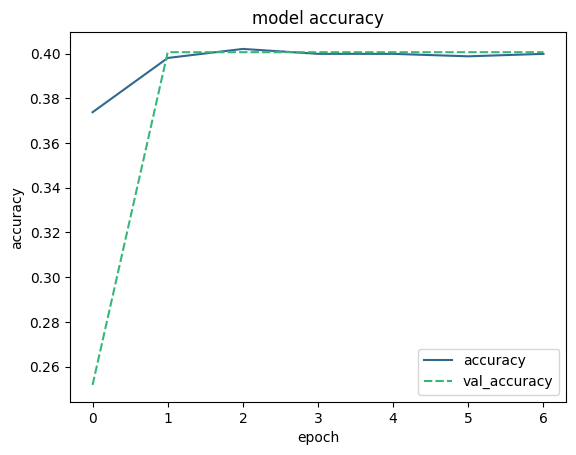

In [34]:
hist = {'accuracy': history.history['accuracy'], 'val_accuracy': history.history['val_accuracy']}
sns.lineplot(hist, palette='viridis')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

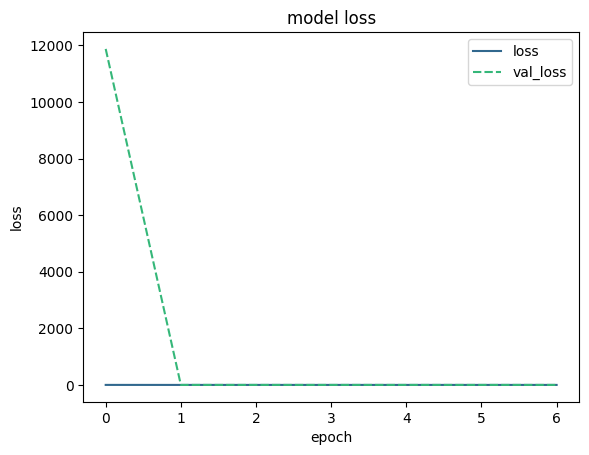

In [35]:
hist = {'loss': history.history['loss'], 'val_loss': history.history['val_loss']}
sns.lineplot(hist, palette='viridis')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

El modelo tiene un desempeño para nada óptimo. Veremos entonces que tal lo hace un modelo generado con ayuda de Pytorch Lightning.

In [25]:
class ConvolutionalNetwork(LightningModule):

    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(16 * 54 * 54, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)
        self.fc4 = nn.Linear(20, len(class_names))

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16 * 54 * 54)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)
        return F.log_softmax(X, dim=1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("val_loss", loss)
        self.log("val_acc", acc)

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("test_loss", loss)
        self.log("test_acc", acc)

In [26]:
model = ConvolutionalNetwork()

trainer = pl.Trainer(max_epochs=30)
trainer.fit(model, datamodule)
val_loader = datamodule.val_dataloader()
trainer.test(dataloaders=val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | conv1 | Conv2d | 168    | train
1 | conv2 | Conv2d | 880    | train
2 | fc1   | Linear | 5.6 M  | train
3 | fc2   | Linear | 10.2 K | train
4 | fc3   | Linear | 1.7 K  | train
5 | fc4   | Linear | 84     | train
-----------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.447    Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_0/checkpoints/epoch=29-step=3930.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_0/checkpoints/epoch=29-step=3930.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.49425286054611206    │
│         test_loss         │    5.1077680587768555     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 5.1077680587768555, 'test_acc': 0.49425286054611206}]

Aunque sus resultados son un poco mejores que el modelo de keras, siguen siendo resultados muy bajos para un clasificador. Por lo que procedemos a utilizar nuevamente la librería de Pytorch Lightning. Esta vez, sobre la transformación aplicaremos una normalización sobre su gradiente de colores. Podemos ver las imágenes después y antes de la normalización.

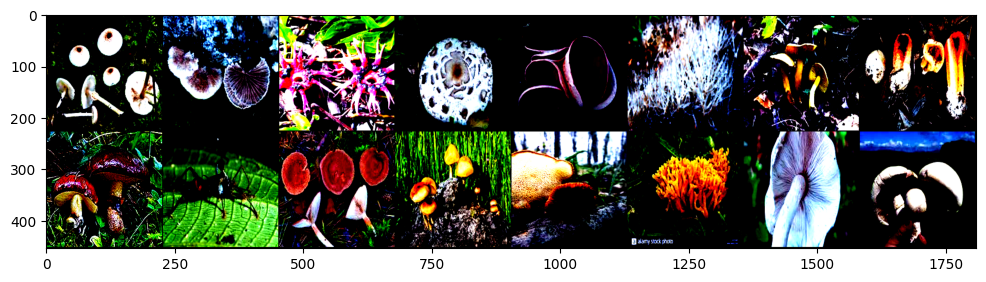

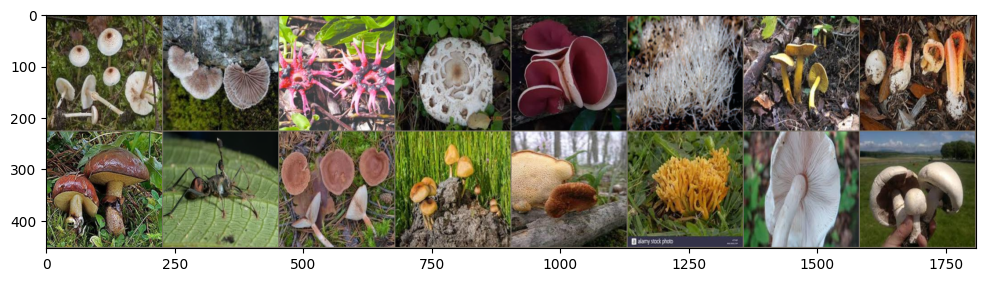

In [27]:
for images, labels in datamodule.val_dataloader():
    break
im=make_grid(images,nrow=8)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                   std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

Evaluamos nuestro modelo entrenado con el dataset de validación. Vemos entonces que sus scores son muy buenos en comparación a los que teníamos en la etapa de entrenamiento.

In [28]:
device = torch.device("cpu")

model.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in datamodule.val_dataloader():
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

print(classification_report(y_true,y_pred,target_names=class_names,digits=4))

                              precision    recall  f1-score   support

   edible mushroom sporocarp     0.8654    0.8036    0.8333       112
            edible sporocarp     0.8947    0.8095    0.8500        63
poisonous mushroom sporocarp     0.8414    0.8592    0.8502       142
         poisonous sporocarp     0.8611    0.9073    0.8836       205

                    accuracy                         0.8602       522
                   macro avg     0.8657    0.8449    0.8543       522
                weighted avg     0.8607    0.8602    0.8597       522



Generamos una matriz de confusión para su análisis posterior.

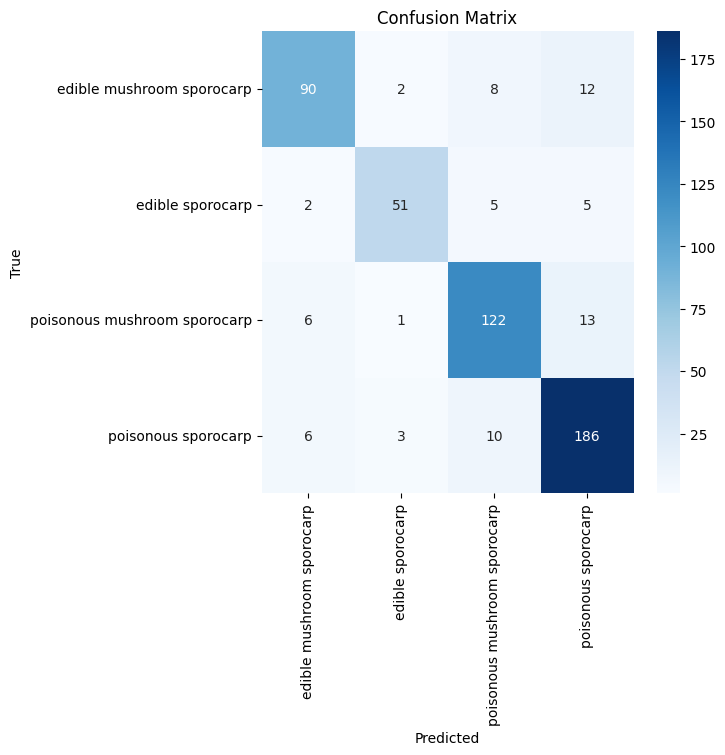

In [30]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Conclusiones

El problema de clasificación de hongos en venenosos y comestibles es uno de vital importancia, y uno en el que los humanos, especialmente sin experiencia previa, podrían tener dificultad. Mediante la implementación de una red neuronal convolucional y la librería de Pytorch Lightning logramos generar un clasificador que puede en un nivel aceptable clasificarlos. Vemos gracias a la matriz de confusión que tiene una mayor precisión en los hongos y esporocarpos venenosos, esto podría deberse al tamaño del dataset en estas clases en comparación a los comestibles. De igual manera, es lo que uno buscaría para este tipo de clasificador. Esto por que se preferiría que clasifique hongos comestibles como venenosos (un error "inofensivo") a que ocurriera lo contrario (lo cual podría ser mortal).

Podría ser que teniendo un dataset balanceado cambiaran estas métricas de puntaje. También puede ser que implementando etiquetado de los datos (con bounding boxes) se consiga un trabajo de mayor calidad. En cualquier caso la limpieza de los datos considero que sería lo fundamental para generar un mejor clasificador.